# NN Multiclass

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from rich import print
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [2]:
def prepare_data_loaders(df, batch_size=64, test_size=0.3, random_state=42):
    """
    Prepare data loaders for training and validation
    """
    # Initialize preprocessing objects
    label_encoder = LabelEncoder()
    scaler = StandardScaler()

    # Prepare features and labels
    x_train = df.drop(['is_benign', 'category', 'attack'], axis=1).values
    y_train = df['category']

    # Encode labels as integers
    y_train = label_encoder.fit_transform(y_train)

    # Split data
    x_train_data, x_val_data, y_train_data, y_val_data = train_test_split(
        x_train, y_train, test_size=test_size, random_state=random_state
    )

    # Scale features
    x_train_scaled = scaler.fit_transform(x_train_data)
    x_val_scaled = scaler.transform(x_val_data)

    # Convert to PyTorch tensors
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_data, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val_data, dtype=torch.long)

    # Create datasets and loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'val_dataset': val_dataset,
        'input_size': x_train.shape[1],
        'num_classes': len(label_encoder.classes_),
        'class_counts': torch.bincount(y_train_tensor),
        'y_train_tensor': y_train_tensor,
        'classes': label_encoder.classes_
    }

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.layers(x)

class ResidualBlock(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(size),
            nn.Linear(size, 2*size),
            nn.LeakyReLU(0.1),
            nn.Linear(2*size, size),
            nn.Dropout(0.1),
        )
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        identity = x
        out = self.block(x)
        out += identity
        return self.activation(out)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()

        # Feature extraction path
        self.feature_extractor = FeatureExtractor(input_size)

        # Main processing path with residual connections
        self.main_path = nn.Sequential(
          ResidualBlock(512),
          ResidualBlock(512),
          ResidualBlock(512),
          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(0.2),
          nn.Dropout(0.1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)

        # Process through main path
        main_features = self.main_path(features)

        # Classification
        output = self.classifier(main_features)

        return output

def get_optimizer(model, learning_rate=0.001, weight_decay=1e-5):
    """
    Create optimizer for the model
    """
    return torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999)
    )

def get_scheduler(optimizer):
    """
    Create learning rate scheduler
    """
    return torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=5
    )

# Example of model initialization (to be used in the training loop):
def initialize_model(input_size, num_classes, device):
    """
    Initialize the model, optimizer, and scheduler
    """
    model = NeuralNetwork(input_size, num_classes).to(device)
    optimizer = get_optimizer(model)
    scheduler = get_scheduler(optimizer)

    return model, optimizer, scheduler

In [4]:
class TrainingMetrics:
    def __init__(self):
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'accuracy': [],
            'learning_rates': []
        }

    def update(self, train_loss, val_loss, accuracy, lr):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['accuracy'].append(accuracy)
        self.history['learning_rates'].append(lr)

    def plot(self, dataset_name):
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # Plot metrics on primary y-axis
        metrics = ['train_loss', 'val_loss', 'accuracy']
        colors = ['blue', 'orange', 'green']
        for metric, color in zip(metrics, colors):
            ax1.plot(self.history[metric], 
                    label=metric.replace('_', ' ').title(),
                    color=color)
        
        # Create secondary y-axis for learning rate
        ax2 = ax1.twinx()
        ax2.set_yscale('log')  # Set logarithmic scale for learning rate
        ax2.plot(self.history['learning_rates'], 
                label='Learning Rate',
                color='red',
                linestyle='--')
        
        # Customize plot
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Metrics Value')
        ax2.set_ylabel('Learning Rate (log scale)')
        
        # Combine legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
        
        plt.title(f'Training Metrics - {dataset_name}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [5]:
def train_model(model, train_loader, val_loader, val_dataset, criterion, optimizer, 
                scheduler, epochs, device, dataset_name, save_dir, goat):
    
    print(f"Training on dataset: {dataset_name}")
    
    metrics = TrainingMetrics()
    best_val_loss = float('inf')
    best_accuracy = 0.0
    patience = 9 if goat != 0 else 15
    counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        num_batches = len(train_loader)
        
        for batch_X, batch_y in tqdm(train_loader, desc=f"{dataset_name} - Epoch {epoch + 1}/{epochs}", bar_format='{desc}: {elapsed}'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == batch_y).sum().item()

        # Compute metrics
        avg_train_loss = epoch_loss / num_batches
        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / len(val_dataset)
        current_lr = optimizer.param_groups[0]['lr']
        
        metrics.update(avg_train_loss, avg_val_loss, accuracy, current_lr)
        
        # Update best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_accuracy': best_accuracy,
                'best_val_loss': best_val_loss
            }, Path(save_dir) / f"best_model_{dataset_name}.pth")
            
        if best_accuracy > goat:
            counter = 0
            goat = best_accuracy
            patience = 15
        else:
            counter += 1
        
        scheduler.step(avg_val_loss)
        
        if counter >= patience:
            print(f"Early stopping after {patience} epochs without improvement")
            break
            
    metrics.plot(dataset_name)
    return best_accuracy, best_val_loss, goat

def evaluate_model(model, val_loader, classes, device):
    """Enhanced model evaluation with custom visualizations"""
    y_pred = []
    y_true = []
    probs = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            probs.append(torch.softmax(outputs, dim=1).cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    probs = np.concatenate(probs)
    
    # Plot metrics
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Custom Classification Report Visualization
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }
    
    metrics_df = pd.DataFrame(metrics, index=classes)
    metrics_df.plot(kind='bar', ax=ax1)
    ax1.set_title('Classification Metrics by Class')
    ax1.set_xticklabels(classes, rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Enhanced Confusion Matrix
    sns.heatmap(confusion_matrix(y_true, y_pred, normalize='true'),
                annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=ax2)
    ax2.set_title('Normalized Confusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics for logging
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_f1': f1_score(y_true, y_pred, average='macro'),
        'metrics_by_class': metrics_df
    }

def train_on_multiple_datasets(dataset_paths, save_dir='/kaggle/working', merged=False):
    """
    Train the model sequentially on multiple datasets
    """
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create save directory
    save_dir = Path(save_dir)

    # Training configuration
    config = {
        'batch_size': 64,
        'epochs': 30,
        'learning_rate': 0.001,
        'weight_decay': 1e-5,
    }

    results = {}
    goat = 0.0

    # Train on each dataset sequentially
    for dataset_path in dataset_paths:
        dataset_name = Path(dataset_path).stem

        # Load and prepare data
        df = pd.read_csv(dataset_path, low_memory=False)
        
        if merged:
            df['category'] = df['category'].replace({
                                        'DDoS': 'DOS_DDOS',
                                        'DoS': 'DOS_DDOS'
                                    })
        
        data = prepare_data_loaders(df, batch_size=config['batch_size'])
        class_counts = data['class_counts'] 

        # Initialize model, optimizer, and criterion
        model = NeuralNetwork(data['input_size'], data['num_classes']).to(device)
        optimizer = get_optimizer(model, config['learning_rate'], config['weight_decay'])
        scheduler = get_scheduler(optimizer)

        # Calculate class weights for balanced training
        total_samples = len(data['y_train_tensor'])
        class_weights = total_samples / (len(data['class_counts']) * data['class_counts'])
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

        best_accuracy, best_val_loss, goat = train_model(
            model=model,
            train_loader=data['train_loader'],
            val_loader=data['val_loader'],
            val_dataset=data['val_dataset'],
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            epochs=config['epochs'],
            device=device,
            dataset_name=dataset_name,
            save_dir=save_dir,
            goat=goat
        )

        # Check if the best model file exists
        best_model_path = Path(save_dir) / f"best_model_{dataset_name}.pth"
        if not best_model_path.exists():
            print(f"Best model file for {dataset_name} not found. Skipping evaluation.")
            continue

        # Load best model for evaluation
        checkpoint = torch.load(best_model_path, weights_only=True);
        model.load_state_dict(checkpoint['model_state_dict'])

        # Evaluate model
        # print(f"\nEvaluating model for dataset: {dataset_name}")
        evaluate_model(model, data['val_loader'], data['classes'], device)

        # Store results
        results[dataset_name] = {
            'best_accuracy': best_accuracy,
            'best_val_loss': best_val_loss
        }

    # Print final results summary in a table using tabulate
    results_df = pd.DataFrame(results).T
    results_df.columns = ['Best Accuracy', 'Best Validation Loss']
    print("\nTraining Results Summary:")
    print(tabulate(results_df, headers='keys', tablefmt='psql'))

Using device: cuda

Training on dataset: train_labeled

train_labeled - Epoch 1/30: 00:58
train_labeled - Epoch 2/30: 00:57
train_labeled - Epoch 3/30: 00:58
train_labeled - Epoch 4/30: 00:57
train_labeled - Epoch 5/30: 00:57
train_labeled - Epoch 6/30: 00:57
train_labeled - Epoch 7/30: 00:58
train_labeled - Epoch 8/30: 00:57
train_labeled - Epoch 9/30: 00:57
train_labeled - Epoch 10/30: 00:57
train_labeled - Epoch 11/30: 00:58
train_labeled - Epoch 12/30: 00:57
train_labeled - Epoch 13/30: 00:57
train_labeled - Epoch 14/30: 00:57
train_labeled - Epoch 15/30: 00:57
train_labeled - Epoch 16/30: 00:58
train_labeled - Epoch 17/30: 00:57
train_labeled - Epoch 18/30: 00:57
train_labeled - Epoch 19/30: 00:58
train_labeled - Epoch 20/30: 00:57


Early stopping after 15 epochs without improvement

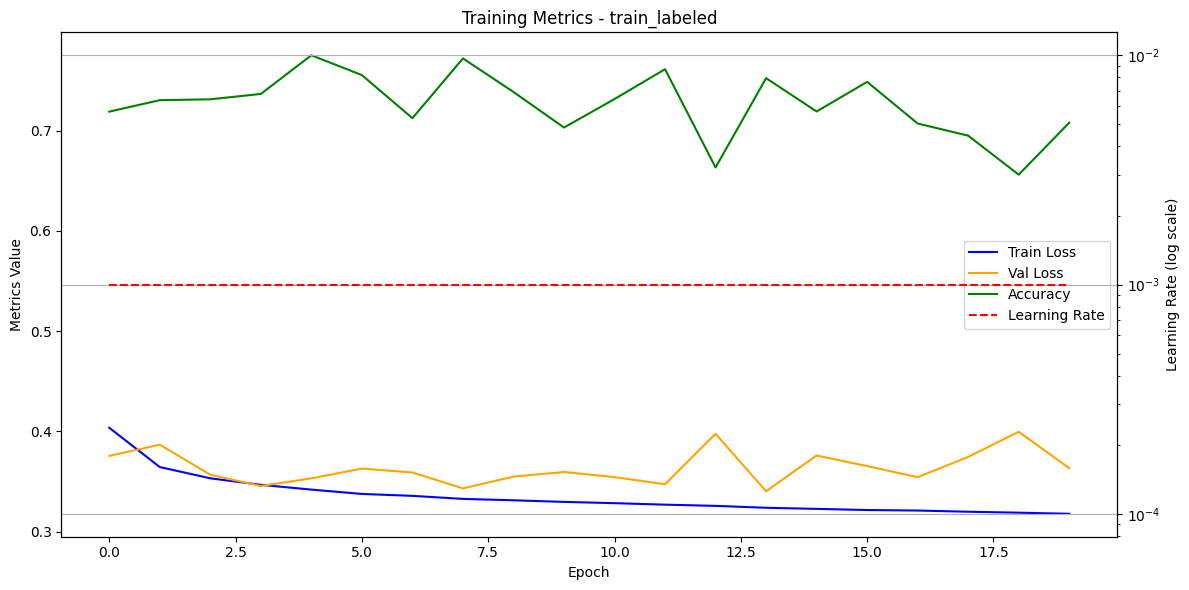

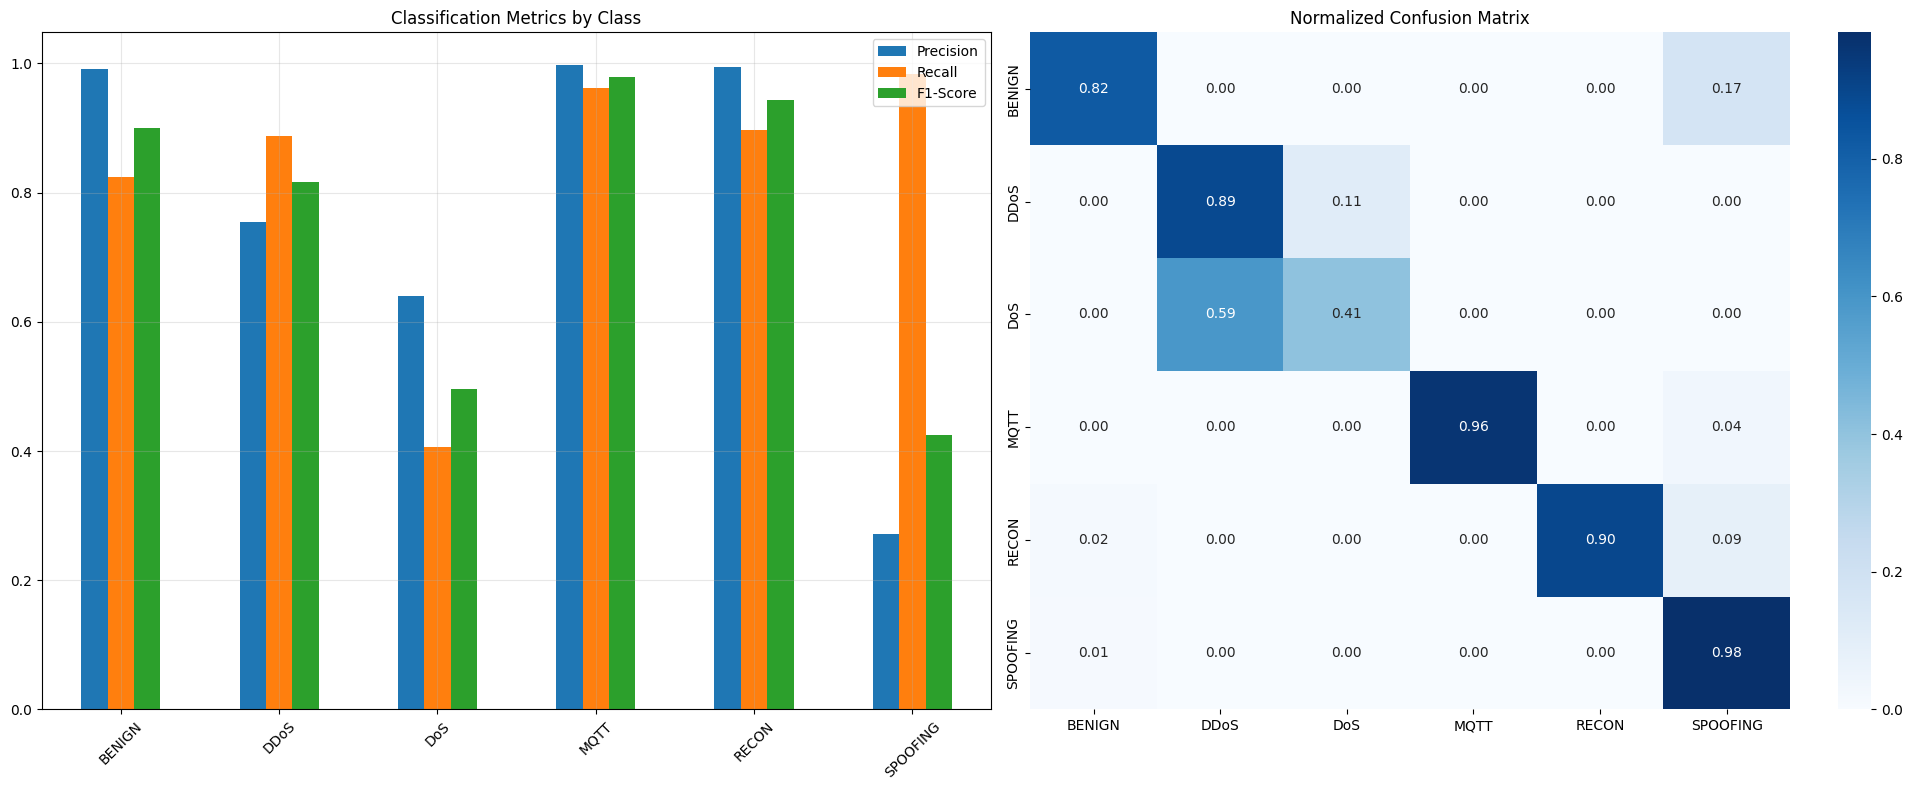

Training on dataset: train_smote

train_smote - Epoch 1/30: 00:33
train_smote - Epoch 2/30: 00:33
train_smote - Epoch 3/30: 00:33
train_smote - Epoch 4/30: 00:33
train_smote - Epoch 5/30: 00:34
train_smote - Epoch 6/30: 00:34
train_smote - Epoch 7/30: 00:34
train_smote - Epoch 8/30: 00:34
train_smote - Epoch 9/30: 00:34
train_smote - Epoch 10/30: 00:33
train_smote - Epoch 11/30: 00:33
train_smote - Epoch 12/30: 00:33
train_smote - Epoch 13/30: 00:33
train_smote - Epoch 14/30: 00:33
train_smote - Epoch 15/30: 00:33
train_smote - Epoch 16/30: 00:34
train_smote - Epoch 17/30: 00:33
train_smote - Epoch 18/30: 00:33
train_smote - Epoch 19/30: 00:33
train_smote - Epoch 20/30: 00:34
train_smote - Epoch 21/30: 00:33
train_smote - Epoch 22/30: 00:33
train_smote - Epoch 23/30: 00:33
train_smote - Epoch 24/30: 00:33


Early stopping after 15 epochs without improvement

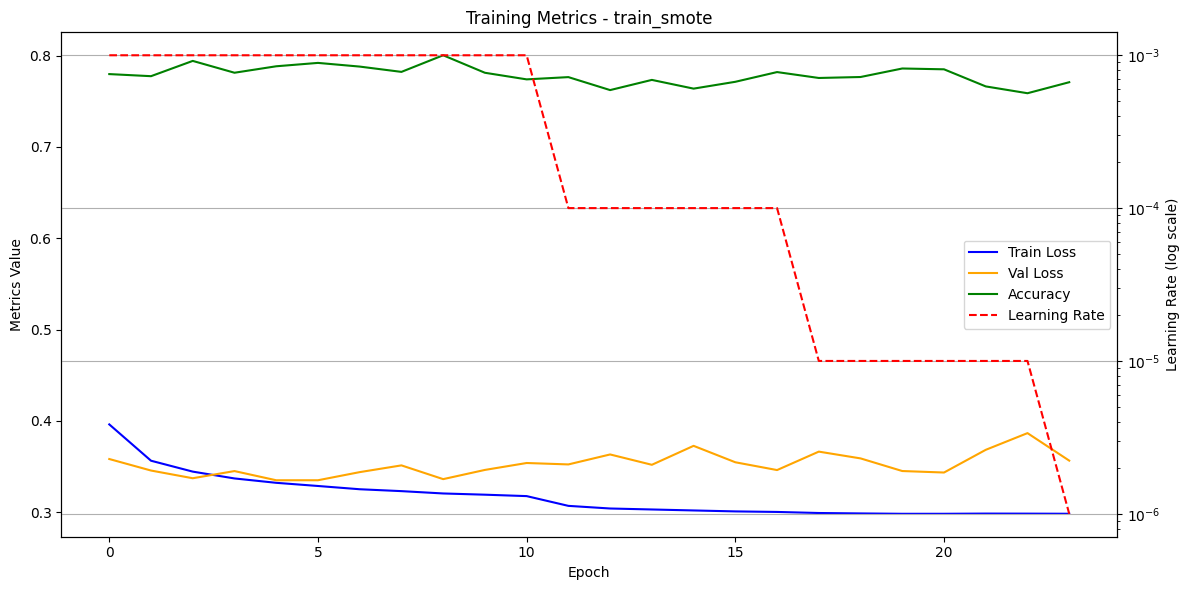

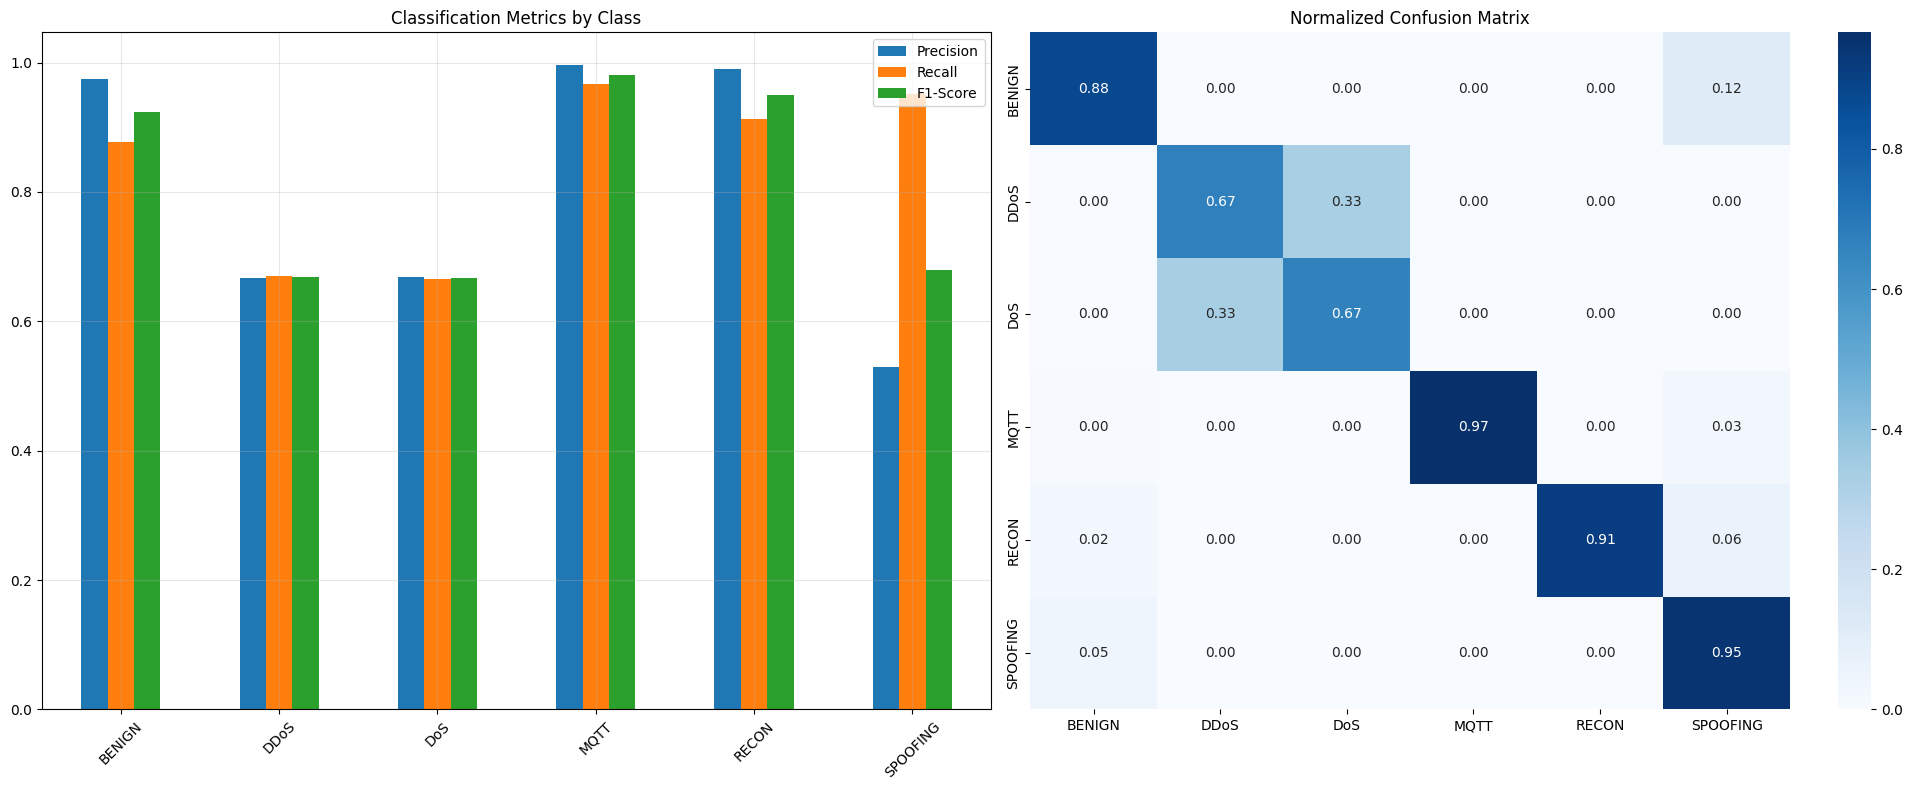

Training on dataset: train_sel_hclust

train_sel_hclust - Epoch 1/30: 00:58
train_sel_hclust - Epoch 2/30: 00:58
train_sel_hclust - Epoch 3/30: 00:58
train_sel_hclust - Epoch 4/30: 00:58
train_sel_hclust - Epoch 5/30: 00:58
train_sel_hclust - Epoch 6/30: 00:57
train_sel_hclust - Epoch 7/30: 00:58
train_sel_hclust - Epoch 8/30: 00:58
train_sel_hclust - Epoch 9/30: 00:58


Early stopping after 9 epochs without improvement

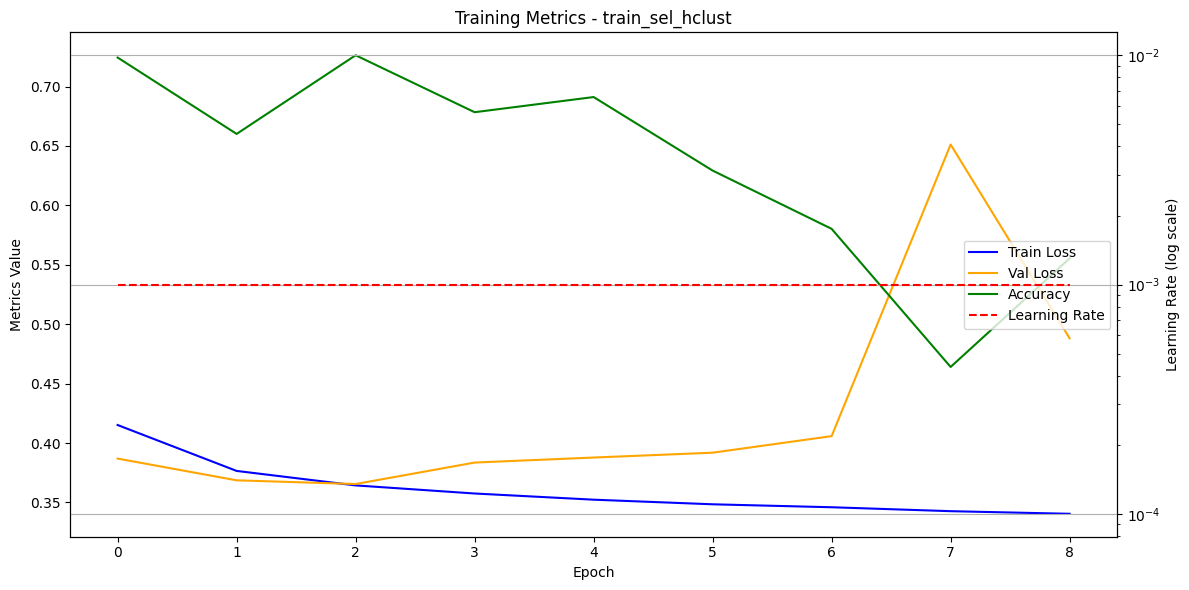

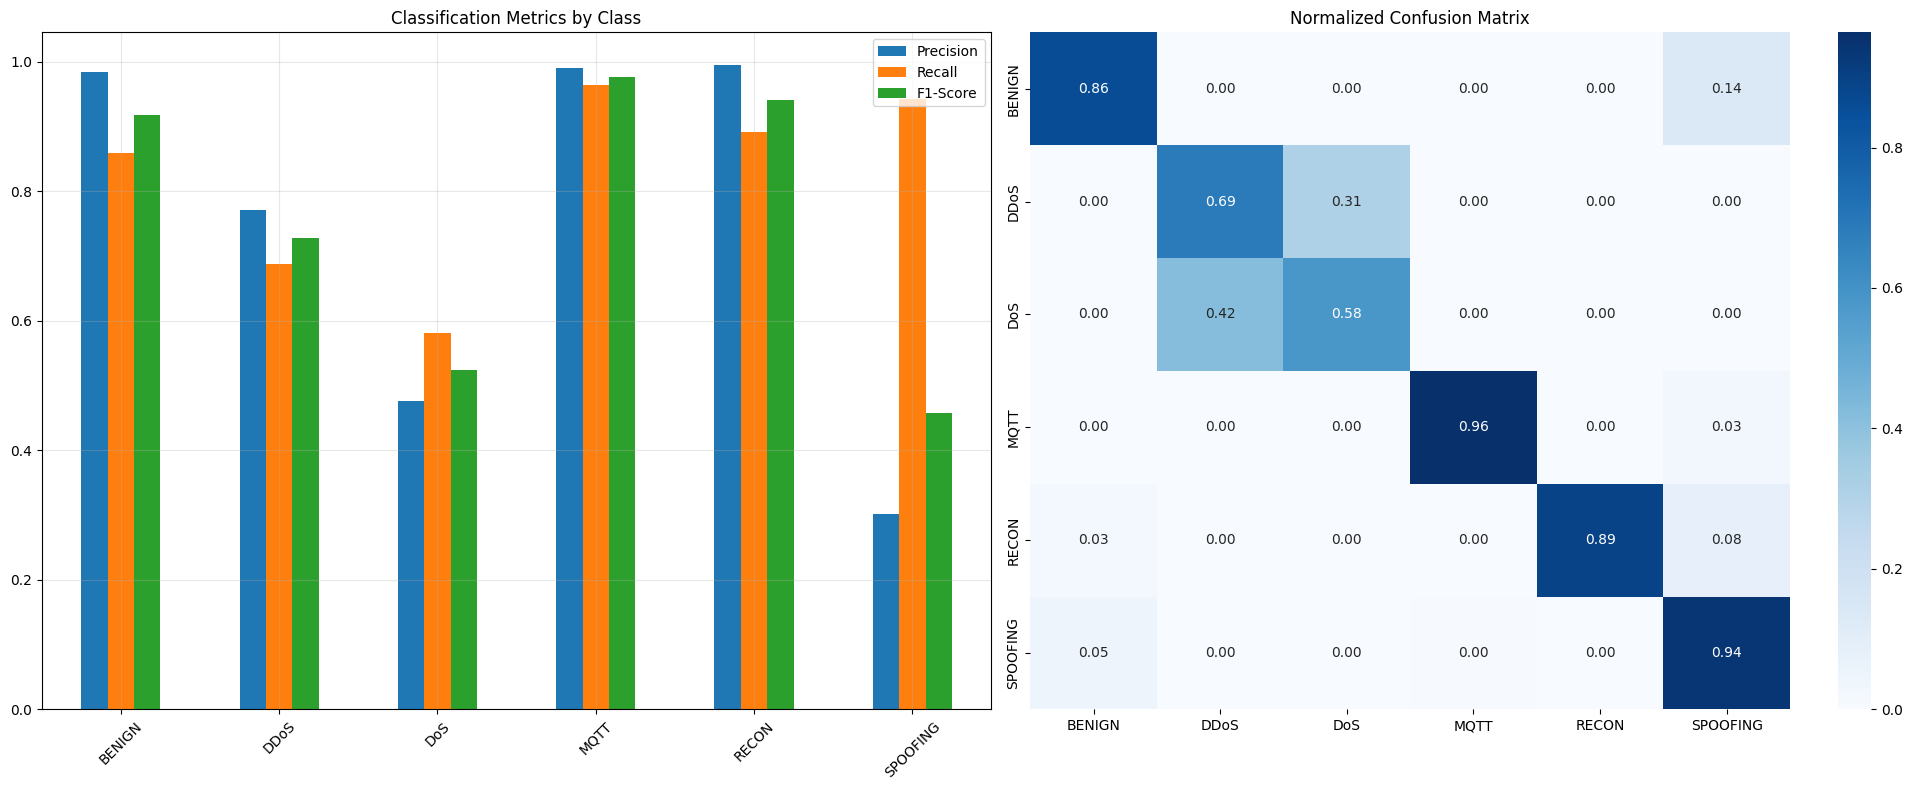

Training Results Summary:

+------------------+-----------------+------------------------+
|                  |   Best Accuracy |   Best Validation Loss |
|------------------+-----------------+------------------------|
| train_labeled    |        0.775291 |               0.353133 |
| train_smote      |        0.800388 |               0.336325 |
| train_sel_hclust |        0.726309 |               0.365527 |
+------------------+-----------------+------------------------+

In [6]:
dataset_paths = [
    "/kaggle/input/dataset/train_labeled.csv",
    "/kaggle/input/dataset/train_smote.csv",
    "/kaggle/input/dataset/train_sel_hclust.csv",
]

train_on_multiple_datasets(dataset_paths)

Given these result, it's clear how difficult for the model is to distinghuis between DoS and DDos. Given this fact, we'll now try to merge the two category, (of course is done with logic, at their root are attack much similar between eachother)

Using device: cuda

Training on dataset: train_labeled

train_labeled - Epoch 1/30: 00:58
train_labeled - Epoch 2/30: 00:58
train_labeled - Epoch 3/30: 00:58
train_labeled - Epoch 4/30: 00:58
train_labeled - Epoch 5/30: 00:58
train_labeled - Epoch 6/30: 00:58
train_labeled - Epoch 7/30: 00:58
train_labeled - Epoch 8/30: 00:58
train_labeled - Epoch 9/30: 00:57
train_labeled - Epoch 10/30: 00:57
train_labeled - Epoch 11/30: 00:58
train_labeled - Epoch 12/30: 00:58
train_labeled - Epoch 13/30: 00:58
train_labeled - Epoch 14/30: 00:58
train_labeled - Epoch 15/30: 00:58
train_labeled - Epoch 16/30: 00:58
train_labeled - Epoch 17/30: 00:58
train_labeled - Epoch 18/30: 00:58
train_labeled - Epoch 19/30: 00:57
train_labeled - Epoch 20/30: 00:58
train_labeled - Epoch 21/30: 00:58
train_labeled - Epoch 22/30: 00:58
train_labeled - Epoch 23/30: 00:58
train_labeled - Epoch 24/30: 00:58
train_labeled - Epoch 25/30: 00:58
train_labeled - Epoch 26/30: 00:57
train_labeled - Epoch 27/30: 00:58
train_labeled - Epoch 28/30: 00:58
train_labeled - Epoch 29/30: 

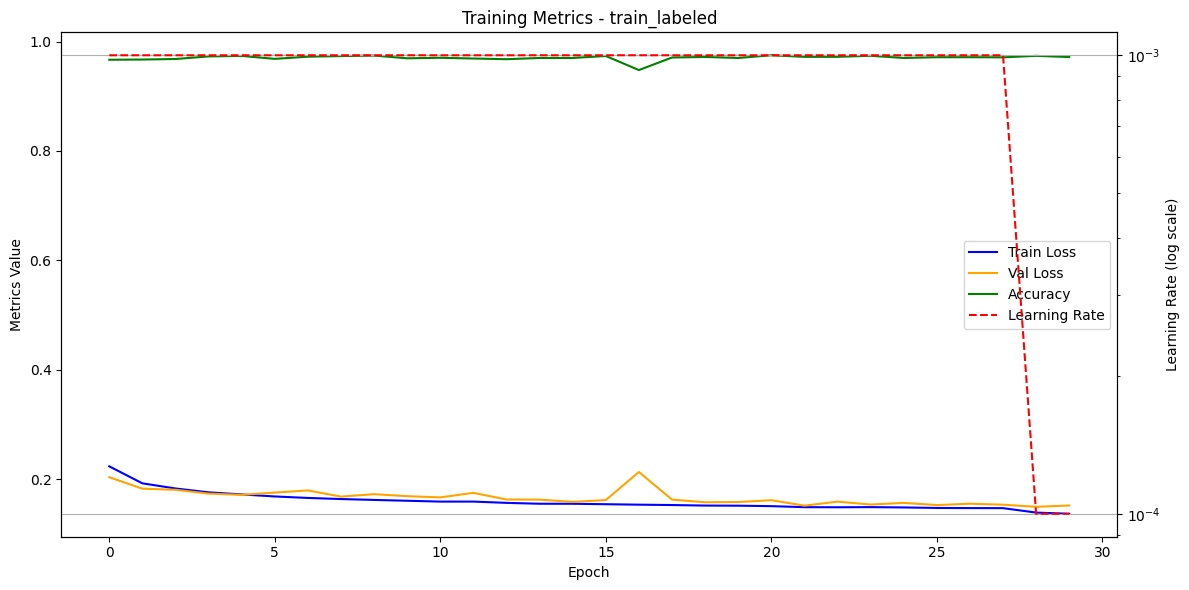

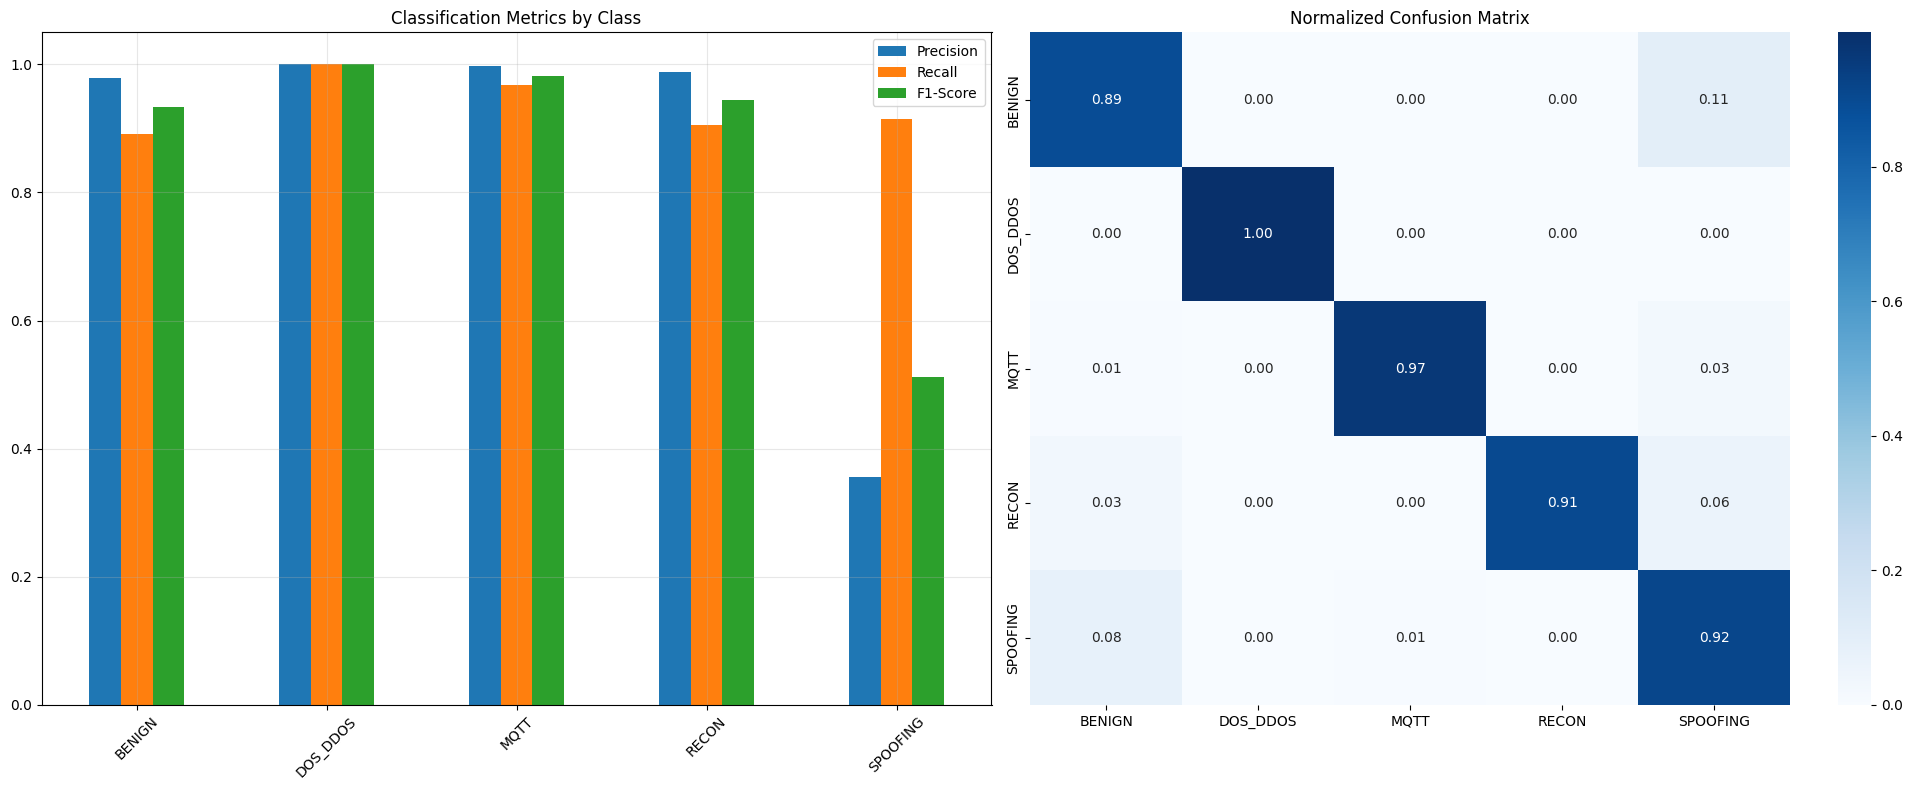

Training on dataset: train_smote

train_smote - Epoch 1/30: 00:34
train_smote - Epoch 2/30: 00:33
train_smote - Epoch 3/30: 00:33
train_smote - Epoch 4/30: 00:33
train_smote - Epoch 5/30: 00:33
train_smote - Epoch 6/30: 00:33
train_smote - Epoch 7/30: 00:33
train_smote - Epoch 8/30: 00:33
train_smote - Epoch 9/30: 00:33


Early stopping after 9 epochs without improvement

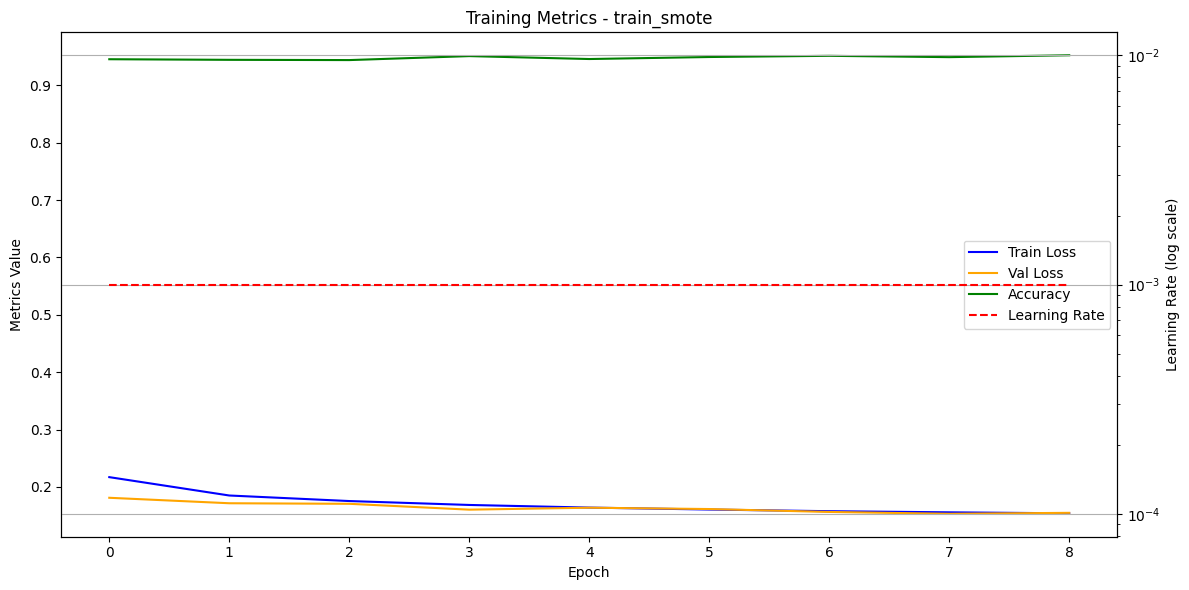

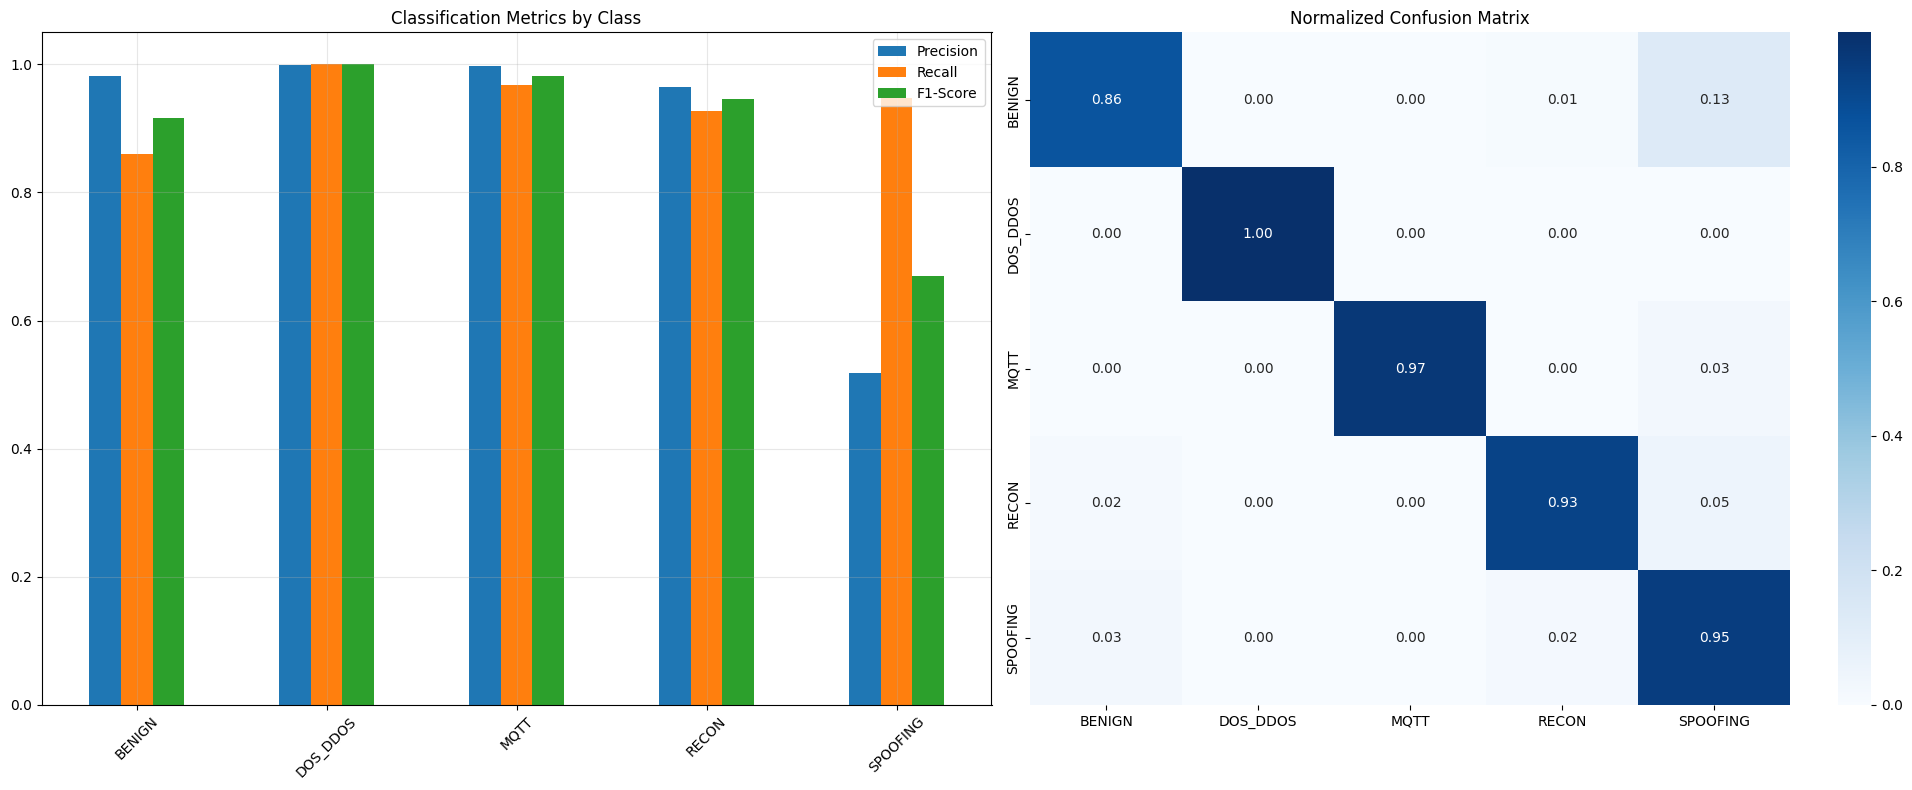

Training on dataset: train_sel_hclust

train_sel_hclust - Epoch 1/30: 00:58
train_sel_hclust - Epoch 2/30: 00:57
train_sel_hclust - Epoch 3/30: 00:58
train_sel_hclust - Epoch 4/30: 00:58
train_sel_hclust - Epoch 5/30: 00:58
train_sel_hclust - Epoch 6/30: 00:58
train_sel_hclust - Epoch 7/30: 00:58
train_sel_hclust - Epoch 8/30: 00:58
train_sel_hclust - Epoch 9/30: 00:57


Early stopping after 9 epochs without improvement

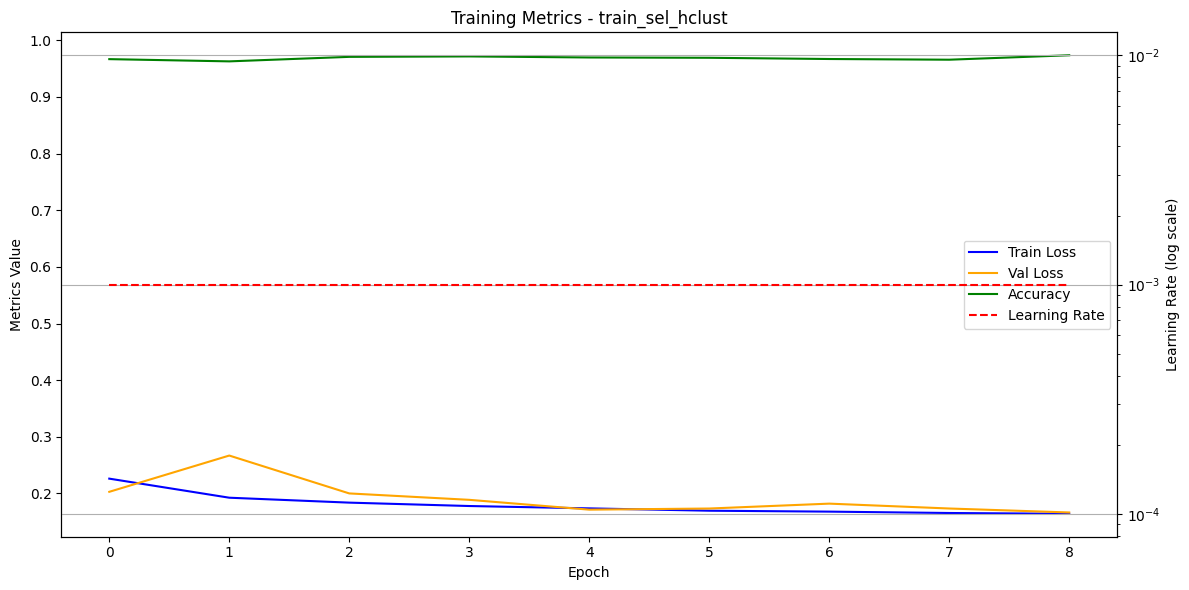

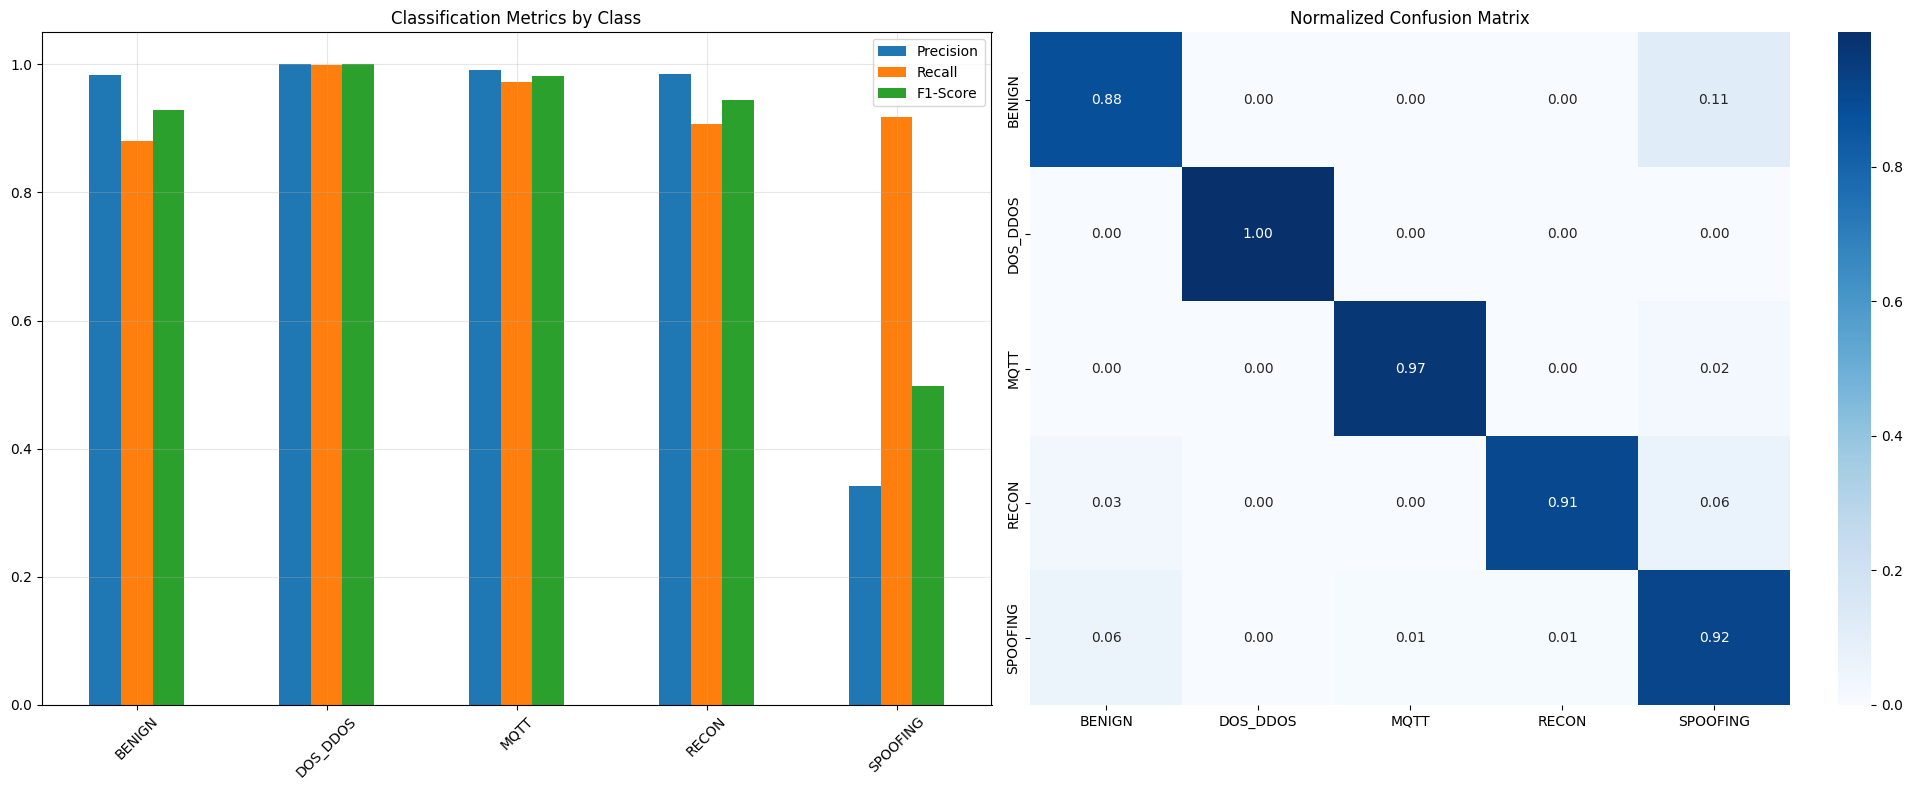

Training Results Summary:

+------------------+-----------------+------------------------+
|                  |   Best Accuracy |   Best Validation Loss |
|------------------+-----------------+------------------------|
| train_labeled    |        0.975032 |               0.161444 |
| train_smote      |        0.952267 |               0.154779 |
| train_sel_hclust |        0.97367  |               0.166454 |
+------------------+-----------------+------------------------+

In [7]:
train_on_multiple_datasets(dataset_paths, merged = True)